<h1>Stock Market Analysis Project</h1>
<p>This project involves acquiring and analyzing public data of stock market prices. The analysis will focus on evaluating the risk of a stock. The results of this analysis will be used in a Monte Carlo simulation to predict future stock prices.</p>
<h2>Essential Questions</h2>
<p>The questions that will be answered during this project are:
    <ol>
        <li>What was the change in price of the stock over time?</li>
        <li>What was the daily return of the stock on average?</li>
        <li>What was the moving average of the various stocks?</li>
        <li>What was the correlation between different stocks' closing prices</li>
        <li>What was the correlation between different stocks' daily returns?</li>
        <li>How much value do we put at risk by investing in a particular stock?</li>
        <li>How can we attempt to predict future stock behaivor?</li>
    </ol>
</p>

<h2>Basic Analysis of Stock Information</h2>

In [1]:
%%html
<style>
.output_wrapper, .output {
    height:auto !important;
    max-height:1000px;  /* your desired max-height here */
}
.output_scroll {
    box-shadow:none !important;
    webkit-box-shadow:none !important;
}
</style>

In [2]:
# imports
import pandas as pd
from pandas import Series, DataFrame
import numpy as np

#statistics
import scipy.stats as stats

# visualization
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
from matplotlib import gridspec
%matplotlib inline
#matplotlib.rc_file('~/.matplotlib/matplotlibrc')
sns.set(context='talk',style='whitegrid') # set white grid background for seaborn

# data reader
# from pandas.io.data import DataReader  <- Deprecated as of pandas 0.19.0
pd.core.common.is_list_like = pd.api.types.is_list_like
import pandas_datareader.data as web

# date and time stamps
from datetime import datetime
import dateutil.relativedelta as rd

# interation tools
import itertools

In [3]:
tech_list = ['AAPL','GOOG','MSFT','AMZN']
bFetchData = False

for stock in tech_list:
    
    if bFetchData: # fetch data from Quandl
        end = datetime.now() - rd.relativedelta(months=6) # end import six months before today (Quandl limits historical data to > 6 months ago)
        start = datetime(end.year-2,end.month,end.day) # start import a year previous today
    
        # globals()[stock] makes the name of the DataFrame the same as the stock name.
        globals()[stock] = web.DataReader(stock,'quandl',start,end) 
        # Sort dates so the oldest dates appear first     
        globals()[stock].sort_values(by='Date', inplace=True)
        globals()[stock].to_csv(stock+'.csv')
    else: # read data from a csv file saved from a previous fetch
        globals()[stock] = pd.read_csv(stock+'.csv',encoding='utf-8')
        start = globals()[stock]['Date'].iloc[0]
        end = globals()[stock]['Date'].iloc[-1]

    # Convert the date to DateTime format
    globals()[stock]['Date'] = pd.to_datetime(globals()[stock]['Date'])
    # Set the index to the Date
    globals()[stock].set_index('Date',inplace=True)
    print("Stock: {}, start: {}, end: {}".format(stock,start,end))

Stock: AAPL, start: 6/20/2016, end: 3/27/2018
Stock: GOOG, start: 6/20/2016, end: 3/27/2018
Stock: MSFT, start: 6/20/2016, end: 3/27/2018
Stock: AMZN, start: 6/20/2016, end: 3/27/2018


In [4]:
def add_multiindex(df,df2_list,col_list):
    # df is the original dataframe
    # df2_list is a string list of dataframes to be added to the multiindex
    # col_list is the list of columns in the dataframes to append
    
    # Create a dictionary with keywords from df2_list. The values are the DataFrames found in the globals.
    pieces = dict(zip(df2_list,[globals()[x] for x in df2_list]))
    
    # concatenate the pieces given in the dictionary. 
    # Swap the column level order so that columns in the column list can be selected. 
    tmp=pd.concat(pieces,axis=1,sort=False).swaplevel(i=0,j=1,axis=1)[col_list] 
    
    if df.size==0: 
        return tmp
    else:
        # return pd.concat([df,tmp]).sort_index(axis=0)
        return df.join(tmp, on=None, how='outer', lsuffix='', rsuffix='', sort=True).sort_index(axis=1)

# Create a new dataframe that contains only the high, low, close, and adjusted closing values of each stock
stocks_df=add_multiindex(DataFrame(),tech_list,['High','Low','Close','AdjClose','Volume'])

# See https://pandas.pydata.org/pandas-docs/stable/cookbook.html#multiindexing
               

<h3>Adjusted Close historical data</h3>

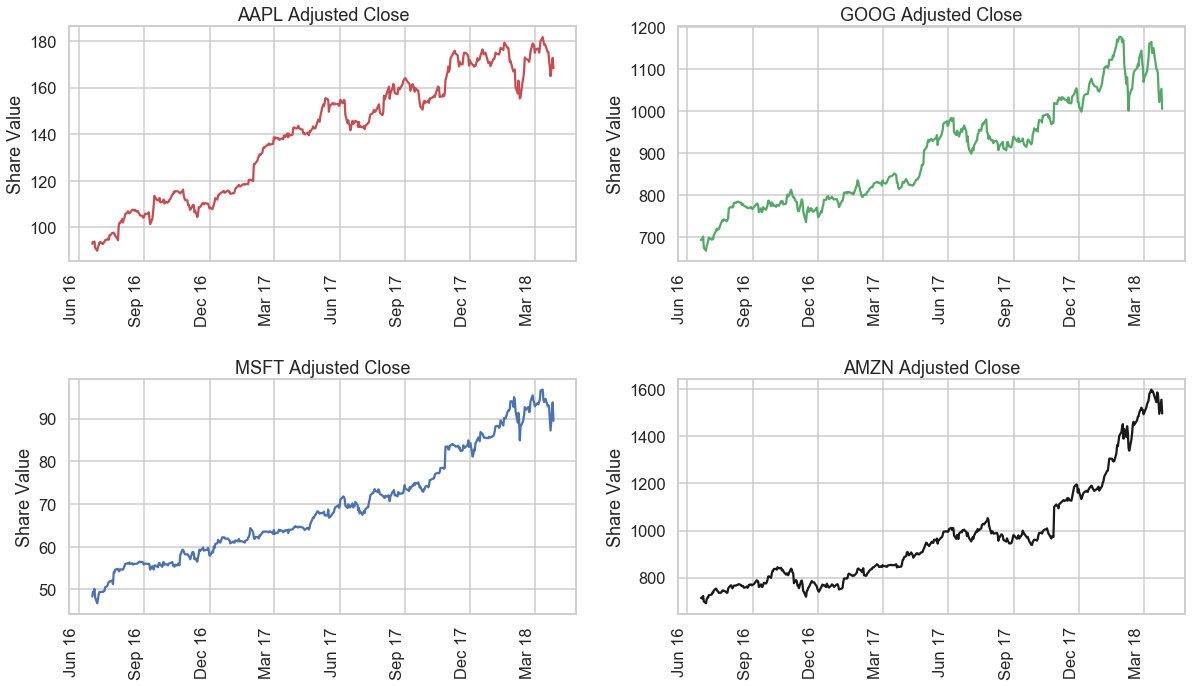

In [5]:
# Graph the historical data
fig, ax = plt.subplots(nrows=2,ncols=2,sharex=False,figsize=(20,12),gridspec_kw={'hspace':0.5})
colors = ['r','g','b','k']

for i,stock in enumerate(tech_list):
    # The i=0 plot will go in the top left (0,0). 
    # The i=1 plot will go top right (0,1).
    # The i=2 plot will go bottom left (1,0).
    # The i=3 plot will go bottom right (1,1).
    
    axi = ax[i//2,i%2]
    
    stocks_df[('AdjClose',stock)].dropna().plot(legend=False,ax=axi,color=colors[i])
    axi.set_title(stock+' Adjusted Close')
    axi.set_xlabel('')
    axi.set_ylabel('Share Value')
       
    # Format the x tick labels as a date for every third month
    triMonths = mdates.MonthLocator(interval = 3)  # every third month
    axi.xaxis.set_major_locator(triMonths)
    tickFmt = mdates.DateFormatter('%b %y')
    axi.xaxis.set_major_formatter(tickFmt)

    # Rotate x tick marks
    [tick.set_rotation(90) for tick in axi.get_xticklabels()]


<h3>Moving Averages of Adjusted Close</h3>

In [6]:
ma_day = [14,28,56] # we will create exponential moving averages for 14-day, 28-day, and 56-day intervals
col_list = []

for ma, stock in itertools.product(ma_day,tech_list):
    
    column_name = "%s-day EMA" %(str(ma)) # e.g. "14-day MA"
    if column_name not in col_list:
        col_list.append(column_name)
    stocks_df[column_name,stock] = globals()[stock]['AdjClose'].ewm(span=ma,min_periods=ma).mean()

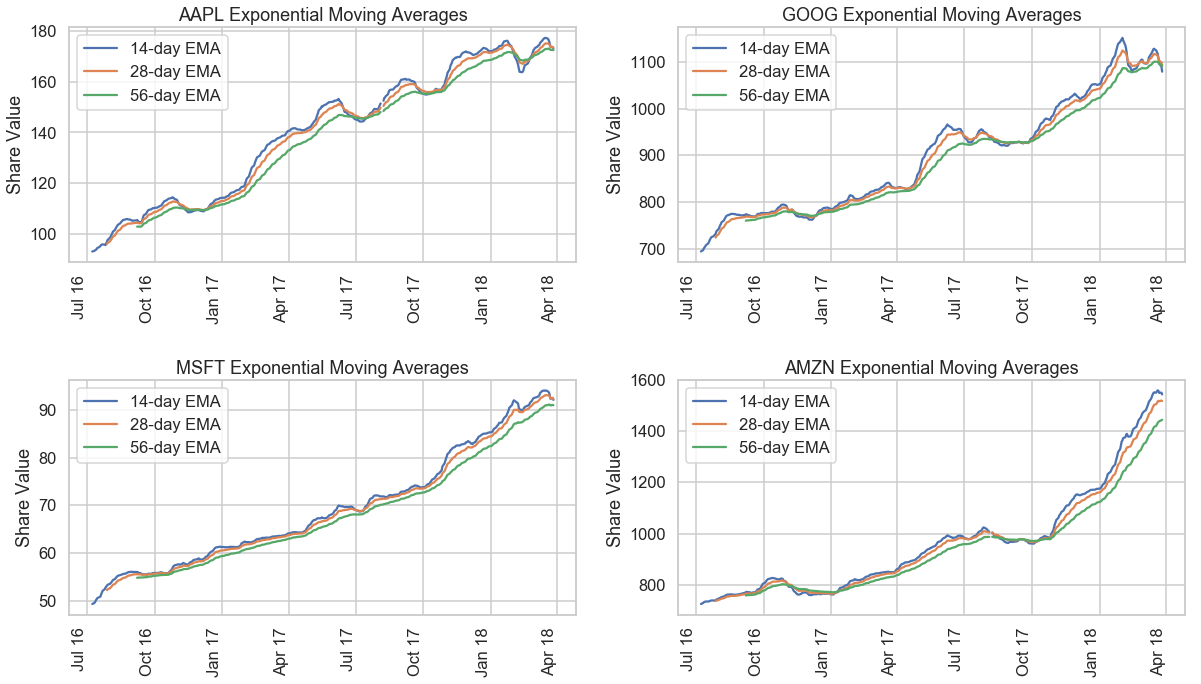

In [7]:
# Graph the moving averages
fig, ax = plt.subplots(nrows=2,ncols=2,sharex=False,figsize=(20,12),gridspec_kw={'hspace':0.5})

for i,stock in enumerate(tech_list):
    # The i=0 plot will go in the top left (0,0). 
    # The i=1 plot will go top right (0,1).
    # The i=2 plot will go bottom left (1,0).
    # The i=3 plot will go bottom right (1,1).
    
    axi = ax[i//2,i%2]
    stocks_df[col_list].xs(stock,axis=1,level=1).plot(subplots=False,ax=axi)
    axi.set_title(stock+' Exponential Moving Averages')
    axi.set_ylabel('Share Value')
    axi.set_xlabel('')
    
    # Format the x tick labels as a date for every third month
    #triMonths = mdates.MonthLocator(interval = 3)  # every third month
    axi.xaxis.set_major_locator(triMonths)
    #tickFmt = mdates.DateFormatter('%b %y')
    axi.xaxis.set_major_formatter(tickFmt)

    # Rotate x tick marks
    [tick.set_rotation(90) for tick in axi.get_xticklabels()]

<h2>Daily Returns</h2>

In [8]:
# Create a new column called "Pct Return" under each stock

for stock in tech_list:
    stocks_df[('Pct Return',stock)]=stocks_df[('AdjClose',stock)].pct_change()
stocks_df.sort_index(axis=1,level=0,sort_remaining=False,inplace=True)

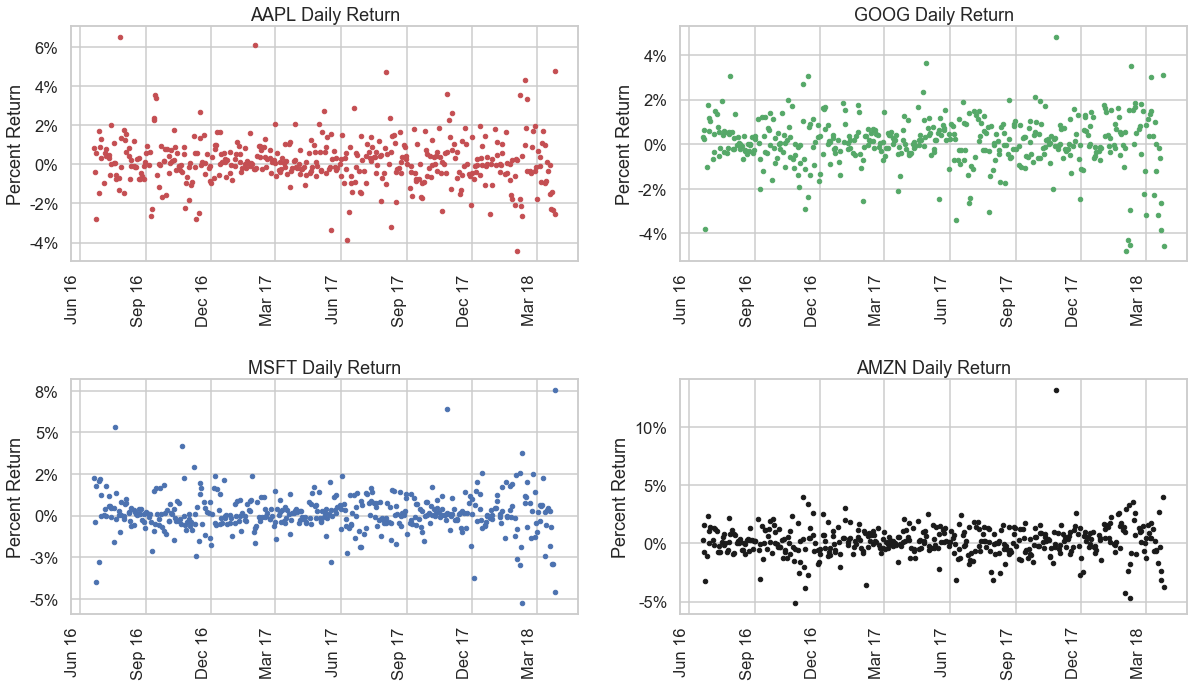

In [9]:
# Graph the daily return for each stock 
fig, ax = plt.subplots(nrows=2,ncols=2,sharex=False,figsize=(20,12),gridspec_kw={'hspace':0.5})

for i, stock in enumerate(tech_list):
    # The i=0 plot will go in the top left (0,0). 
    # The i=1 plot will go top right (0,1).
    # The i=2 plot will go bottom left (1,0).
    # The i=3 plot will go bottom right (1,1).

    axi = ax[i//2,i%2]
    stocks_df[('Pct Return',stock)].plot(legend=False,linestyle='',marker='.',ax=axi,color=colors[i])
    axi.set_title(stock +' Daily Return')
    axi.set_xlabel('')
    axi.set_ylabel('Percent Return')

    # Format the y tick labels as a percentage
    vals = axi.get_yticks()
    axi.set_yticklabels(['{:,.0%}'.format(x) for x in vals])
    
    # Format the x tick labels as a date for every third month
    #triMonths = mdates.MonthLocator(interval = 3)  # every third month
    axi.xaxis.set_major_locator(triMonths)
    #tickFmt = mdates.DateFormatter('%b %y')
    axi.xaxis.set_major_formatter(tickFmt)

    # Rotate x tick marks
    [tick.set_rotation(90) for tick in axi.get_xticklabels()]

<h3> Histograms of daily percent return </h3>

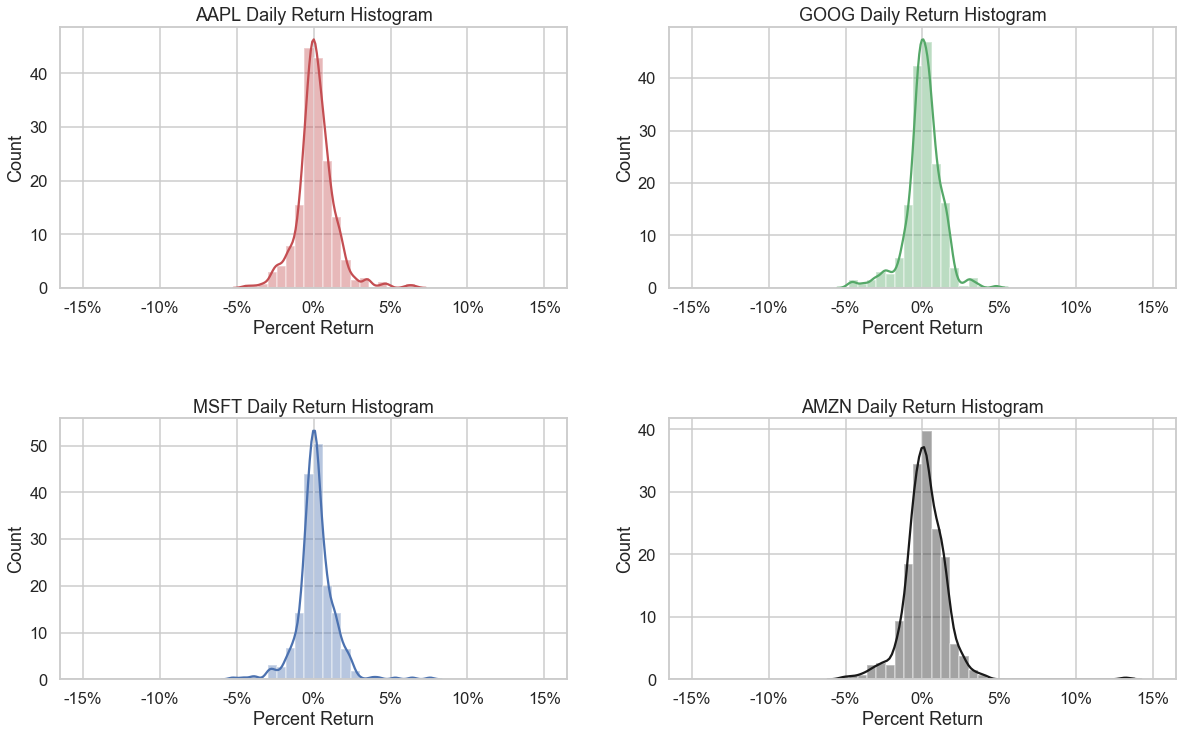

In [10]:
# Graph a histogram of daily return for each stock.
# Note: setting sharex = False and plotting each axis fails to guarantee equal bin sizes.
fig, ax = plt.subplots(nrows=2,ncols=2,sharex=True,figsize=(20,12),gridspec_kw={'hspace':0.5})

for i, stock in enumerate(tech_list):
    # The i=0 plot will go in the top left (0,0). 
    # The i=1 plot will go top right (0,1).
    # The i=2 plot will go bottom left (1,0).
    # The i=3 plot will go bottom right (1,1).
    
    axi = ax[i//2,i%2]
    
    # The range of returns is -15% to +15%, set by the hist_kws dictionary.
    sns.distplot(stocks_df[('Pct Return',stock)].dropna(),
                 ax=axi,color=colors[i], bins=50,
                hist_kws={'range':(-0.15,0.15)})
    axi.set_title(stock +' Daily Return Histogram')
    axi.set_xlabel('Percent Return')
    axi.set_ylabel('Count')
                     
    # Format the tick labels as a percentage
    vals = axi.get_xticks()
    axi.set_xticklabels(['{:,.0%}'.format(x) for x in vals])
    
    #Display the x-axis tickmarks for each subplot
    axi.tick_params(axis='both', which='both',labelbottom=True)

<h3>Comparing returns between different stocks</h3>

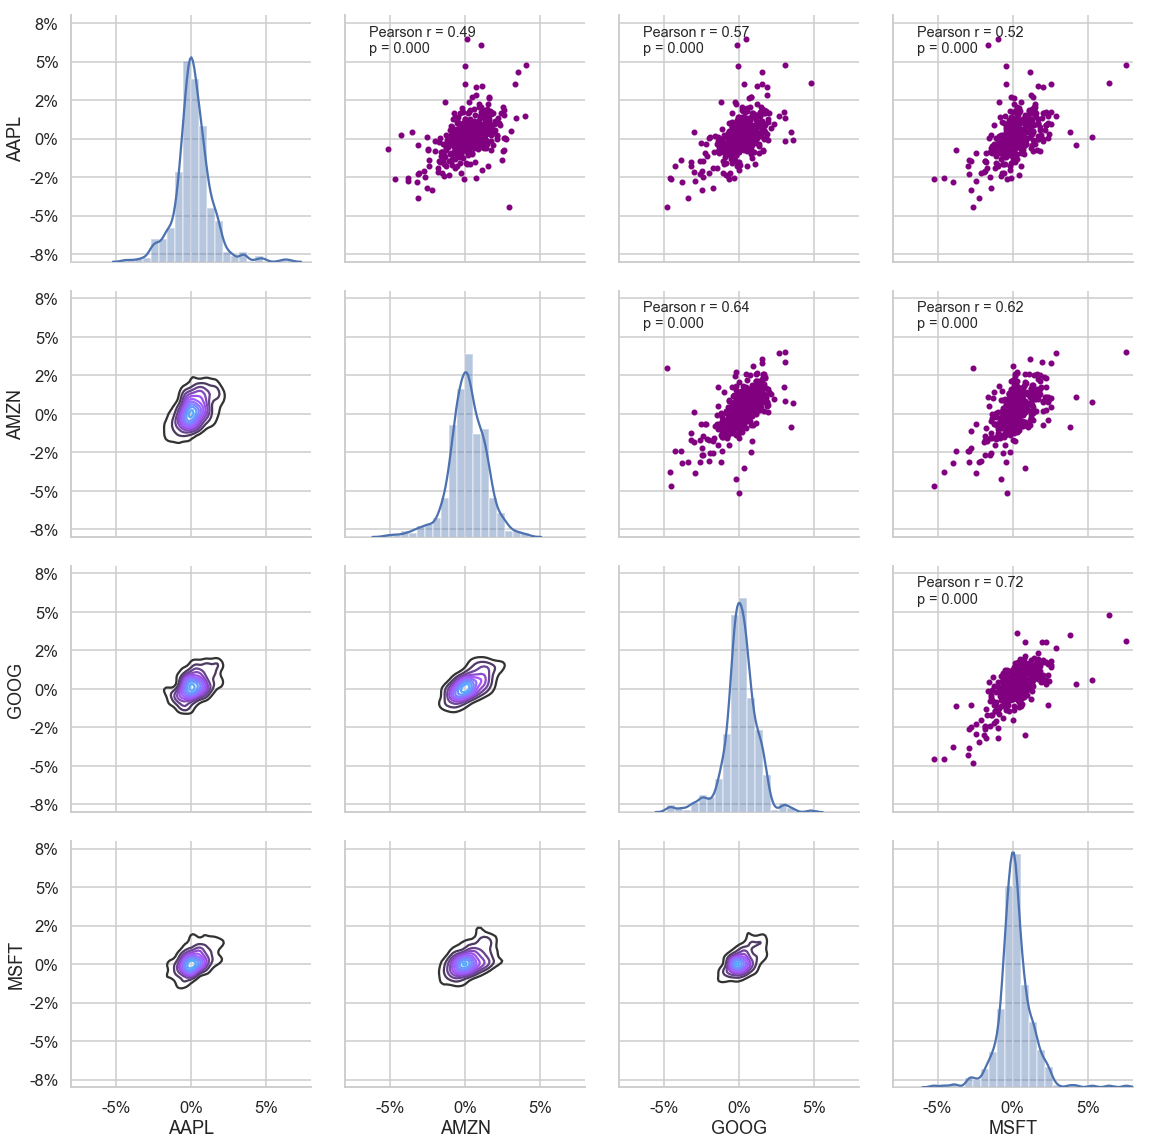

In [11]:
returns_fig = sns.PairGrid(stocks_df['Pct Return'].dropna(),height=4,aspect=1)
my_lim = (-0.08,0.08)
#sns.set(font_scale=1.3)

def corrfunc(x,y,**kws):
    r, p = stats.pearsonr(x,y)
    ax = plt.gca()
    ax.annotate("Pearson r = {:.2f}\np = {:.3f}".format(r,p), 
                xy=(0.1,0.85), 
                xycoords=ax.transAxes,
               fontsize='x-large')

returns_fig.map_upper(plt.scatter,color='purple',marker=".")
returns_fig.map_upper(corrfunc)
returns_fig.map_lower(sns.kdeplot,cmap='cool_d')
returns_fig.map_diag(sns.distplot,bins=30,kde_kws={'clip':my_lim},hist_kws={'range':my_lim})

axes = returns_fig.axes
for i,j in itertools.product(np.arange(4),np.arange(4)):

    axes[i,j].set_xlim(my_lim) 
    vals = axes[i,j].get_xticks()
    axes[i,j].set_xticklabels(['{:,.0%}'.format(x) for x in vals])
    
    axes[i,j].set_ylim(my_lim) 
    vals = axes[i,j].get_yticks()
    axes[i,j].set_yticklabels(['{:,.0%}'.format(x) for x in vals])

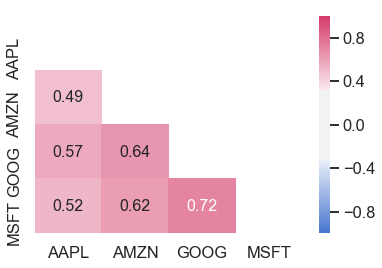

In [12]:
# Create a correlation map
corr = stocks_df['Pct Return'].dropna().corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr,vmin=-1,vmax=+1,cmap=sns.diverging_palette(256,0,sep=80,n=7,as_cmap=True),annot=True,annot_kws={'fontsize':16},mask=mask)

<h3>Comparing closing prices between stocks</h3>

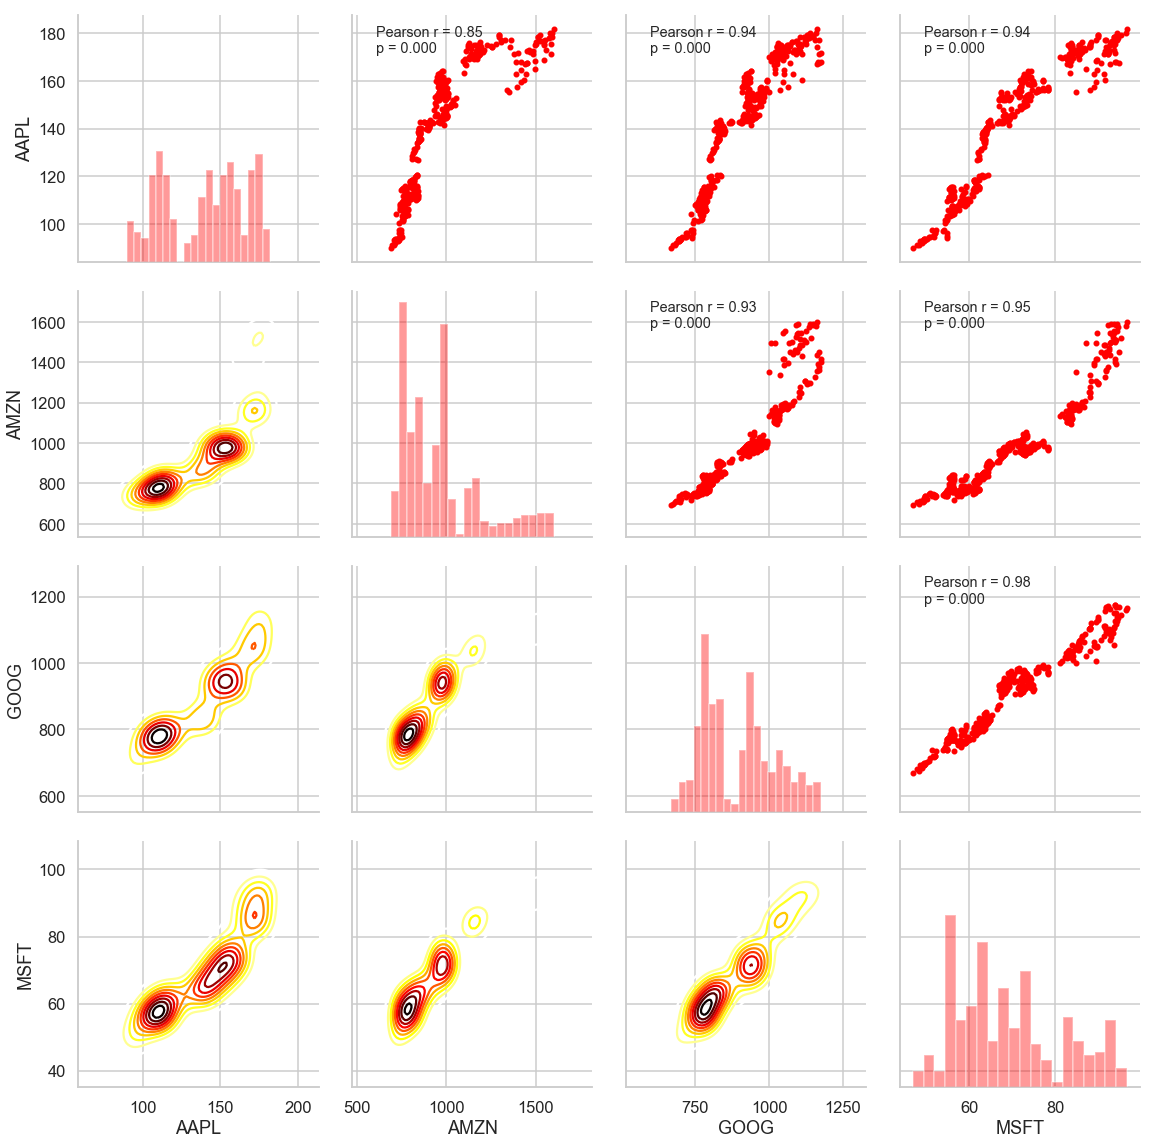

In [13]:
returns_fig = sns.PairGrid(stocks_df['AdjClose'].dropna(),height=4,aspect=1)
#sns.set(font_scale=1.3)

returns_fig.map_upper(plt.scatter,color='red',marker=".")
returns_fig.map_upper(corrfunc)
returns_fig.map_lower(sns.kdeplot,cmap='hot_r')
returns_fig.map_diag(sns.distplot,bins=20,color='red',kde=False)

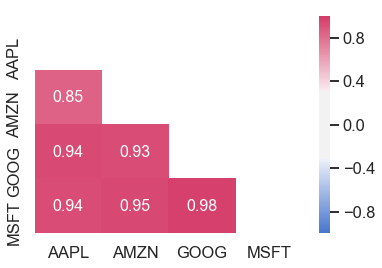

In [14]:
# Create a correlation map
corr = stocks_df['AdjClose'].dropna().corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr,vmin=-1,vmax=+1,cmap=sns.diverging_palette(256,0,sep=80,n=7,as_cmap=True),annot=True,annot_kws={'fontsize':16},mask=mask)

<h2>Price and Volume</h2>

<p>There is a common belief in stock trading that an increase in share volume can serve as an indicator of a trend (either up or down). To test this, one can calculate the Pearson correlation coefficient between the absolute value of percent return and volume traded. </p>

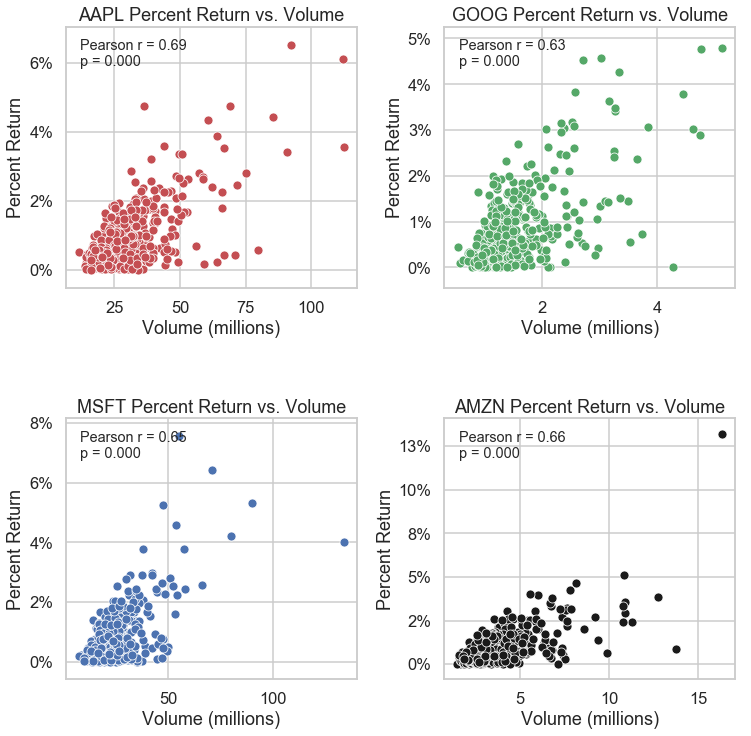

In [15]:
#Graph a scatter plot of pct change vs volume traded.
fig, ax = plt.subplots(nrows=2,ncols=2,sharex=False,sharey=False,figsize=(12,12),gridspec_kw={'hspace':0.5,'wspace':0.3})

for i, stock in enumerate(tech_list):
    # The i=0 plot will go in the top left (0,0). 
    # The i=1 plot will go top right (0,1).
    # The i=2 plot will go bottom left (1,0).
    # The i=3 plot will go bottom right (1,1).
    
    axi = ax[i//2,i%2]
    
    # Extract the x and y values from the DataFrame. Shares are in millions.
    # Since an increase in volume can indicate either a upward or downward trend, take the 
    #    absolute value of percent return.
    myx = stocks_df[('Volume',stock)]/(1.0E6)
    myy = abs(stocks_df[('Pct Return',stock)])
    
    # Determine where neither series has a NaN value
    inc = np.invert(myx.isna() | myy.isna())
    
    # Limit the x and y values only to those where neither series has a NaN value
    myx = myx.loc[inc]
    myy = myy.loc[inc]
    
    # The range of returns is -15% to +15%, set by the hist_kws dictionary.
    sns.scatterplot(myx,myy,color=colors[i],ax=axi,)
    axi.set_title(stock +' Percent Return vs. Volume')
    axi.set_xlabel('Volume (millions)')
    axi.set_ylabel('Percent Return')
   
    # Format the y tick labels as a percentage
    vals = axi.get_yticks()
    axi.set_yticklabels(['{:,.0%}'.format(x) for x in vals])
    
    # Display the x-axis tickmarks for each subplot
    axi.tick_params(axis='both', which='both',labelbottom=True)
    
    # Add the correlation results to the top right corner
    r, p = stats.pearsonr(myx,myy)
    axi.annotate("Pearson r = {:.2f}\np = {:.3f}".format(r,p), 
                xy=(0.05,0.85), 
                xycoords=axi.transAxes,
               fontsize='x-large')
    
    #corrfunc(stocks_df[('Volume',stock)]/(1.0E6),stocks_df[('Pct Return',stock)])

<p>The Pearson correlation coefficient indicates that all four stocks have a correlation between the absolute value of return and volume traded. Based on the location of outliers in each of the graphs, there appears to be a greater spread in returns at higher trade volume. One possible explanation is that investors anticipate movement in a stock, but the stock doesn't necessarily produce returns on that day. This would be especially be true of traders who purchase/sell stock based on how they think a stock will perform over a longer time period than the same day.</p>
<p>To investigate the idea that traders are looking for longer trends, we can compute what I will call <em>change in trend</em>: the average rate of change in the 20-day moving average for 20 days after the date minus the same average rate of change prior to the date. A large difference would indicate that a shift in trend occured on or near that particular day.</p>

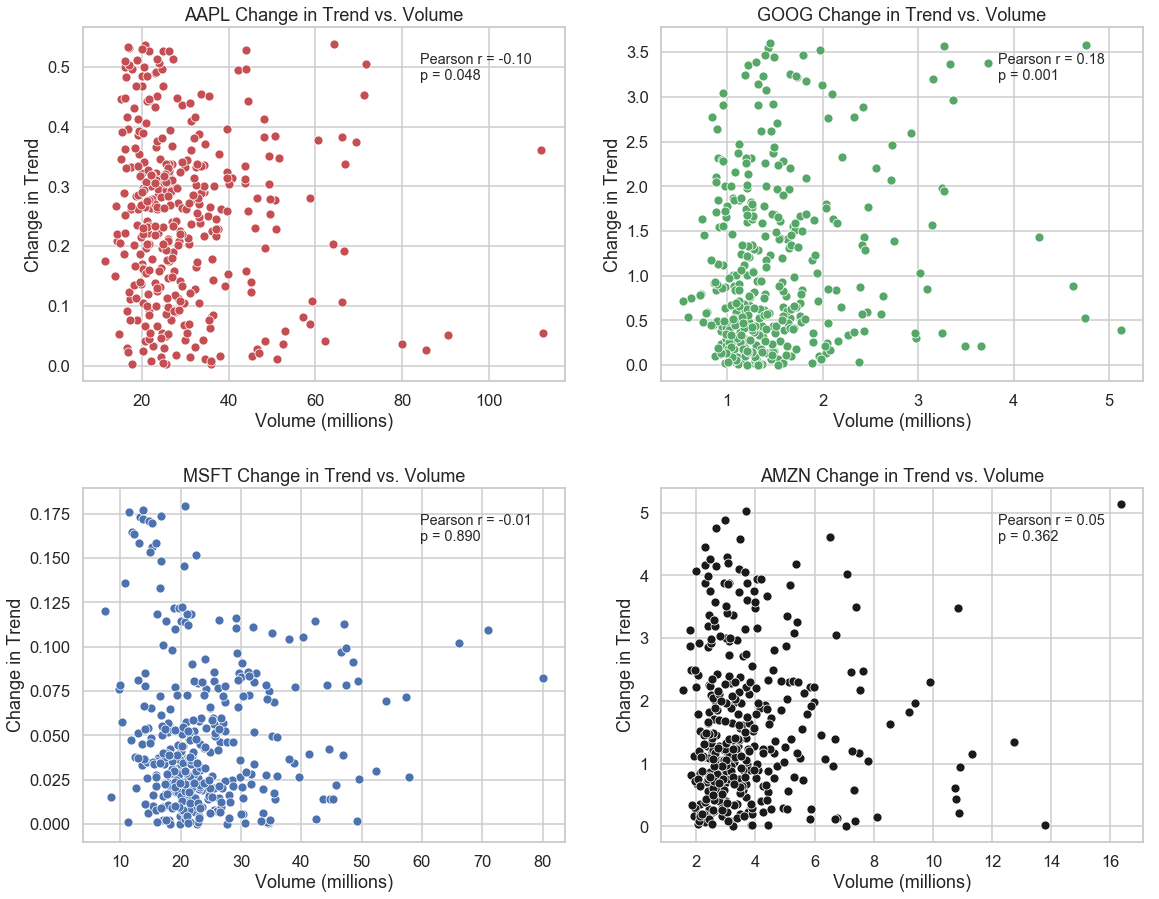

In [16]:
#Graph a scatter plot of pct change vs volume traded.
fig, ax = plt.subplots(nrows=2,ncols=2,sharex=False,sharey=False,figsize=(19,15),gridspec_kw={'hspace':0.3})

for i, stock in enumerate(tech_list):
    # The i=0 plot will go in the top left (0,0). 
    # The i=1 plot will go top right (0,1).
    # The i=2 plot will go bottom left (1,0).
    # The i=3 plot will go bottom right (1,1).
    
    axi = ax[i//2,i%2]
    
    # Extract the x values from the DataFrame. Shares are in millions.
    myx = stocks_df[('Volume',stock)]/(1.0E6)
    
    # Determine the average daily change in 26-day EMA. This average change is
    # equal to the difference between day 1 and day 28 divided by 28.
    dMA = stocks_df[('28-day EMA',stock)].diff(periods=28)/28
    
    # Determine the difference between the previous 28 days (t-28 to t-1) 
    # and the next 20 days (t to t+27). We will use the absolute value because
    # we are not concerned with the direction of the change in trend.
    myy = abs(dMA.diff(periods=28).shift(periods=-27))
    
    # Determine where neither series has a NaN value
    inc = np.invert(myx.isna() | myy.isna())
    
    # Limit the x and y values only to those where neither series has a NaN value
    myx = myx.loc[inc]
    myy = myy.loc[inc]
    
    # The range of returns is -15% to +15%, set by the hist_kws dictionary.
    sns.scatterplot(myx,myy,color=colors[i],ax=axi)
    axi.set_title(stock +' Change in Trend vs. Volume')
    axi.set_xlabel('Volume (millions)')
    axi.set_ylabel('Change in Trend')

    # Display the x-axis tickmarks for each subplot
    axi.tick_params(axis='both', which='both',labelbottom=True)
    
    # Add the correlation results to the top right corner
    r, p = stats.pearsonr(myx,myy)
    axi.annotate("Pearson r = {:.2f}\np = {:.3f}".format(r,p), 
                xy=(0.7,0.85), 
                xycoords=axi.transAxes,
                fontsize='x-large')
    
    #corrfunc(stocks_df[('Volume',stock)]/(1.0E6),stocks_df[('Pct Return',stock)])

<p>A positive correlation between average daily change in the 20-day moving average with trading volume would be consistent with a large number of trend traders accurately predicting when the stock will change its current trend. Two of the four stocks (AAPL and GOOG) show a weak positive correlation with over a 95% level of confidence. The other two stocks show no correlation. It appears that trend traders only account for a minor contribution, if any, to volume traded.</p>

<h2>Stock Risk</h2>
<h3>Risk estimate from daily return distribution</h3>
<p>One estimate of risk comes from the standard deviation of the distribution of daily returns. A higher standard deviation of returns implies a riskier stock.</p>

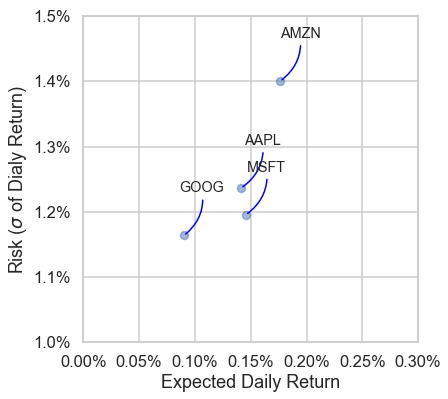

In [17]:
# Define an area for the scatter plot dots
area = np.pi*20

# Create a DataFrame rets as the crossection of pct. daily return
rets = stocks_df['Pct Return'].dropna()

# Plot a scatter plot of daily return standard deviation (risk) vs. expected daily return
fig, ax = plt.subplots(figsize = (6,6))

# Define the limits for the scatter plot
ax.set_xlim(0,0.003)
ax.set_ylim(0.01,0.015)

ax.scatter(rets.mean(),rets.std(),alpha=0.5,s=area)
ax.xaxis.set_major_formatter(ticker.PercentFormatter(xmax=1,decimals=2))
ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1,decimals=1))
ax.set_xlabel('Expected Daily Return')
ax.set_ylabel('Risk ('+ r'$\sigma$' +' of Dialy Return)')

# Annotate each data point
for label, x, y in zip(rets.columns,rets.mean(),rets.std()):
    plt.annotate(
        label,
        xy = (x,y), xytext = (40,40),
        textcoords = 'offset points',ha='right',va='bottom',
        arrowprops = dict(arrowstyle = '-', connectionstyle = 'arc3,rad=-0.3',color='blue')).set_fontsize('x-large')

<h3>Value at risk using quantiles</h3>
<p>Value at risk can be estimated by taking the 0.05 quantile of the distribution of daily returns from a given stock. This will provide an estimate of the maximum loss with a confidence level of 95%.</p>

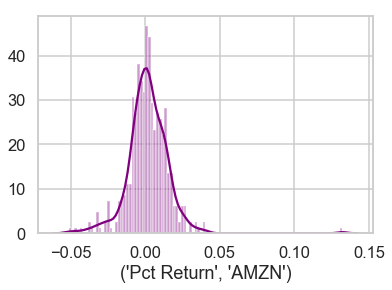

In [18]:
sns.distplot(stocks_df[('Pct Return',stock)].dropna(),bins=100,color='purple')

In [19]:
# Get the 0.05 empirical quantile of daily returns for each stock
for stock in tech_list:
    q = stocks_df[('Pct Return',stock)].quantile(0.05)
    print("{0}: {1:.1f}%".format(stock, q*100))

AAPL: -1.8%
GOOG: -2.0%
MSFT: -1.6%
AMZN: -1.8%


<p>With 95% confidence, a daily investor can expect to have a daily loss less than 2% of their initial investment.</p>

<h2>Periodicity of Stock Data</h2>
<p>To determine if there is any periodicity in the adjusted closing data, I will perform a Fourier transform of the data then graph a power spectrum vs period. If there is any underlying periodic trend, it will show up in the power spectrum as a spike at a particular period.</p>

<h3>Periodicity in adjusted closing price</h3>

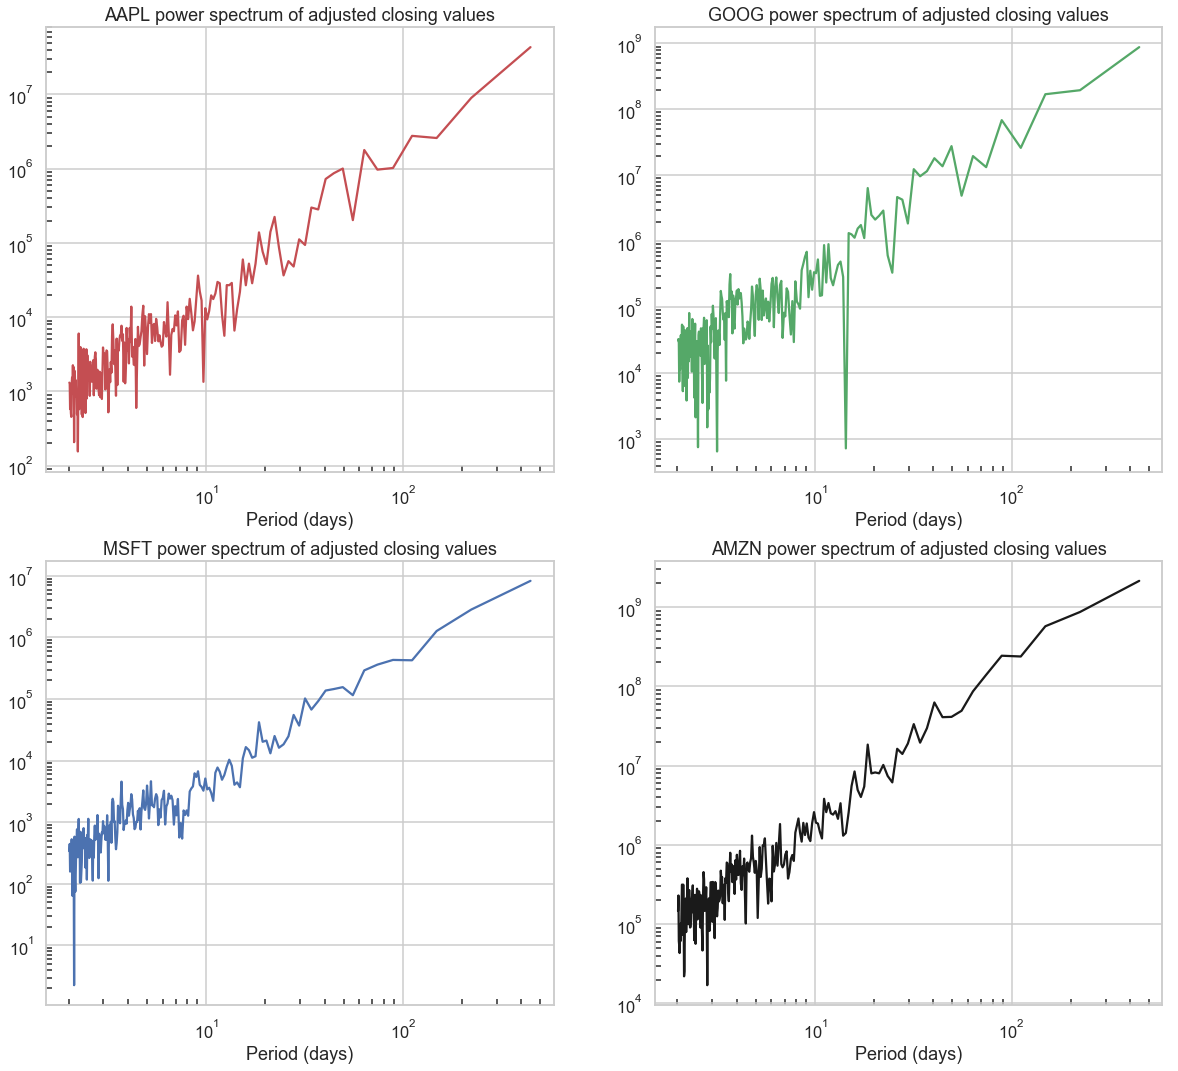

In [20]:
# Compute the array of frequencies for the FFT. The second half of the list of frequencies are negative, so the size of the
# frequency array will be half of the size of the original array.
fft_size = int(stocks_df[('AdjClose',stock)].size/2)

# Compute the array of periods. We cut off the initial value of the frequency to avoid divsion by zero.  
fft_freq = np.fft.fftfreq(stocks_df[('AdjClose','AAPL')].size)
fft_period = 1/(fft_freq[1:fft_size])

# Create a dataframe to store the power spectrum of each transform
power_fft = pd.DataFrame(index=fft_period,columns=tech_list)

fig, ax = plt.subplots(nrows=2,ncols=2,sharex=True,figsize=(20,18))

for i, stock in enumerate(tech_list):
    # The i=0 plot will go in the top left (0,0). 
    # The i=1 plot will go top right (0,1).
    # The i=2 plot will go bottom left (1,0).
    # The i=3 plot will go bottom right (1,1).
    
    axi = ax[i//2,i%2]
    
    # Instead of dropping NA values that will introduce high-frequency noise, we will interpolate to eliminate NaN values
    # The time data are all real values, so using rfft is apporpriate.
    my_fft = np.fft.rfft(stocks_df[('AdjClose',stock)].interpolate())
    
    # Compute the power at each frequency by multiplying the transform by its own conjugate
    # We will also drop the zero-frequency part of the transform in order to display periods rather than frequency.
    power_fft[stock] = np.real(my_fft*np.conj(my_fft))[1:fft_size]
    
    # Plot the graph 
    axi.loglog(fft_period,power_fft[stock],color=colors[i])
    axi.set_title(stock +' power spectrum of adjusted closing values')
    axi.set_xlabel('Period (days)')
                         
    #Display the x-axis tickmarks for each subplot
    axi.tick_params(axis='both', which='both',labelbottom=True)
    
    #Show the minor tick marks for each axis
    axi.tick_params(axis='both', which='minor', direction='in', left=True, bottom=True)

<p>All of the stocks appear to have a power spectrum that is a power law of the period. If any periodicity were present, it would appear as a spike or a bump in these data. There is a possible periodicity in Google's stock somewhere on the order of 3-4 days. There is also a slight bump in the power spectrum of Microsoft stock at that same period.</p>

<p>To test how sensitive this spectrum would be to a periodic change in price, I will take one stock's data (Google) and add a periodic sinusoidal wave whose amplitude is 0.1%, 0.5%, and 1% of the stock's mean adjusted closing price. A random value whose standard deviation is 50% of the amplitude will also be added. The period of the added signal will be 10 days.</p>

[None, None, None, None, None, None, None, None]

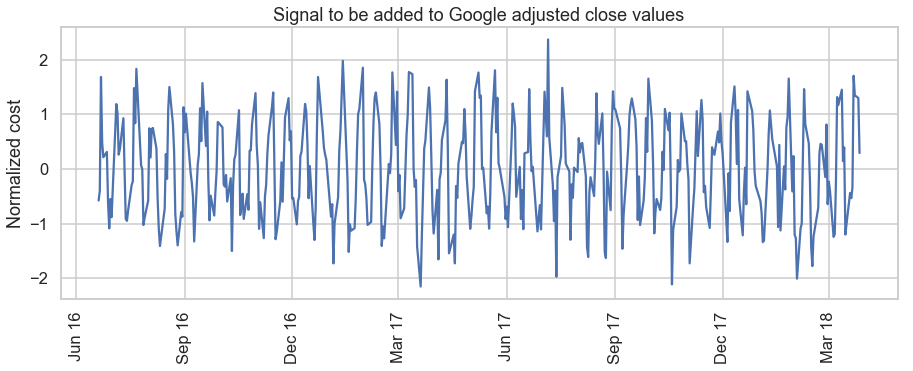

In [21]:
# Determine the amplitude based on the mean of Google's adjusted closing price.
g_mean = stocks_df[('AdjClose','GOOG')].dropna().mean()
amp = np.multiply([0,0.005,0.01,0.02],g_mean)
amp_str = ['0%','0.5%','1%','2%']

# Make a list of the dates from the stock data index
dates = pd.to_datetime(stocks_df.index)

# Create a sine wave whose period is 10 days (each array element is a day's measurement)
s_size = stocks_df[('AdjClose',stock)].size
signal = np.arange(s_size)*2*np.pi/10.
signal = np.sin(signal)

# Add some noise to the signal. The noise has a standard deviation of 0.5
signal += 0.5*np.random.randn(s_size)

# Plot the signal that will be added to the time series
fig, ax = plt.subplots(figsize = (15,5))
plt.plot(dates,signal)
ax.set_title('Signal to be added to Google adjusted close values')
ax.set_ylabel('Normalized cost')

# Format the x tick labels as a date for every third month
#triMonths = mdates.MonthLocator(interval = 3)  # every third month
ax.xaxis.set_major_locator(triMonths)
#tickFmt = mdates.DateFormatter('%b %y')
ax.xaxis.set_major_formatter(tickFmt)

# Rotate the ticks 90 degrees
[tick.set_rotation(90) for tick in ax.get_xticklabels()]

<p>Even though the signal has a random noise component, its period of ten days can easily be distinguished. Below is what it would look like added onto Google's adjusted closing prices.</p>

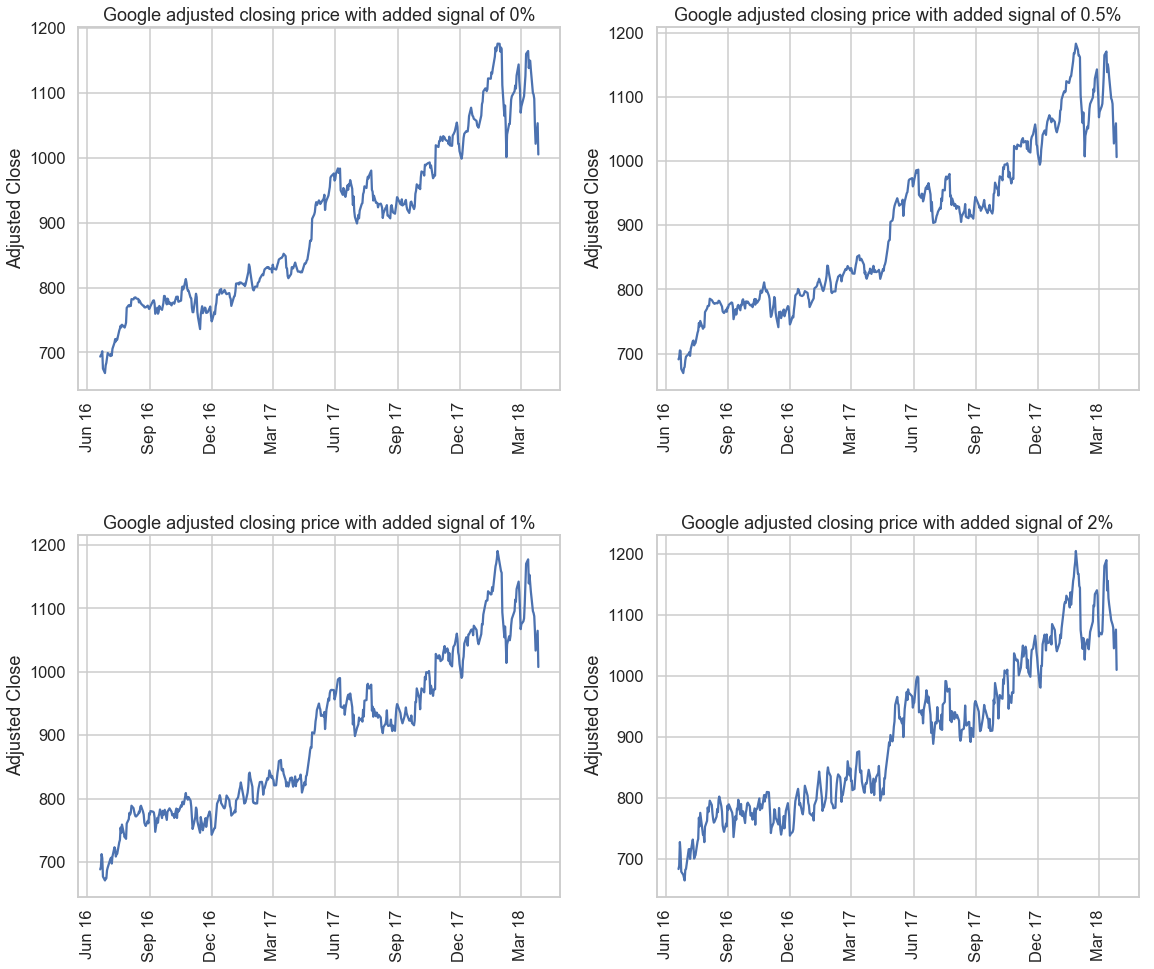

In [22]:
# Create the FFTs and the graphs
fig, ax = plt.subplots(2,2,figsize = (19,16),gridspec_kw={'hspace':0.4})

# Plot the Google adjusted closing price with and without the additional signal overlayed
for i,a in enumerate(amp):
    
    axi= ax[i//2,i%2]
    # Add the noisy signal to the Google adjusted closing price
    my_data = stocks_df[('AdjClose','GOOG')].interpolate()+np.multiply(signal,amp[i])
    # axi.plot(stocks_df[('AdjClose','GOOG')].interpolate())
    axi.plot(dates,my_data)
    
    # Create labels for the graph
    axi.set_title('Google adjusted closing price with added signal of ' + amp_str[i])
    axi.set_ylabel('Adjusted Close')
    
    # Create labels for the graph
    # axi.legend(labels=['Google Adj. Close','Google Adj. Close + added signal'])
    
    # Format the x tick labels as a date for every third month
    #triMonths = mdates.MonthLocator(interval = 3)  # every third month
    axi.xaxis.set_major_locator(triMonths)
    #tickFmt = mdates.DateFormatter('%b %y')
    axi.xaxis.set_major_formatter(tickFmt)

    # Rotate the ticks 90 degrees
    [tick.set_rotation(90) for tick in axi.get_xticklabels()]

<p>The added periodic signal can definitely be seen visually when its amplitude is 2% of the mean adjusted closing price. However, it is less discernable when the amplitude is 1% of the mean adjusted closing price or less. Let's see how the power spectrum is affected by the added signal.</p>

(2, 20)

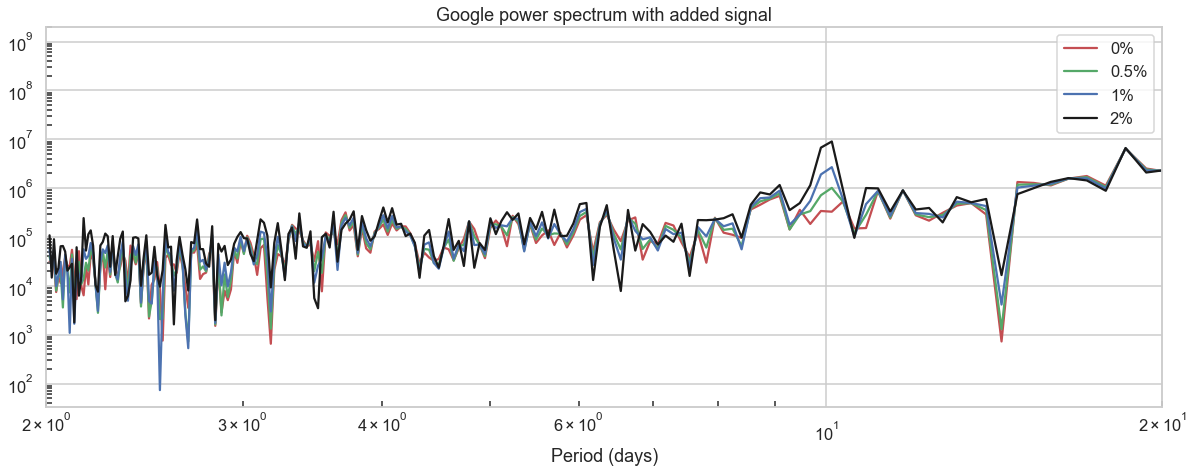

In [23]:
# Create the FFTs and the graphs
fig, ax = plt.subplots(figsize = (20,7))

for i,a in enumerate(amp):
    # Add the noisy signal to the Google adjusted closing price
    my_data = stocks_df[('AdjClose','GOOG')].interpolate()+np.multiply(signal,amp[i])

    # Perform the FFT and compute the power spectrum
    my_fft = np.fft.rfft(my_data)
    power = np.real(my_fft*np.conj(my_fft))[1:fft_size]

    # The i=0 plot will go in the top left (0,0). 
    # The i=1 plot will go top right (0,1).
    # The i=2 plot will go bottom left (1,0).
    # The i=3 plot will go bottom right (1,1).
    
    # Plot the graph 
    ax.loglog(fft_period,power,color=colors[i],)

# Create labels for the graph
ax.legend(labels=amp_str)

ax.set_title('Google power spectrum with added signal')
ax.set_xlabel('Period (days)')
    
#Show the minor tick marks for each axis
ax.tick_params(axis='both', which='minor', direction='in', left=True, bottom=True)

#Show only periods up to 20 days for additional detail
ax.set_xlim(left=2,right=20)

<p>A signal that is 1% of the mean closing cost produces a visible spike in the spectrum at 10 days well above the general trend. A signal that is 2% of the mean closing cost would certainly be visible in this spectrum. If Google or the other stocks do have some periodicity, its amplitude is likely not more than 1% of the mean closing cost. This is consistent with the standard deviation of the daily return percentages of 1.3 to 1.6%.</p>

<h2>Trading Strategies</h2>

<h3>ADX + RSI strategy</h3>
<a href="https://www.moneyshow.com/articles/currency-26465/">Money Show,"Two Indicators, One Profitable FX Trade"</a>
<h4>Strong Uptrend</h4> 

<p>Buy 100 shares when all of the following occur:
    <ul>
       <li>ADX is above 30</li>
       <li>14-day EMA is rising: difference between 14-day EMA today and 4 days ago is &gt; 1%.</li>
       <li>Price action is above 14-day EMA.</li>
       <li>RSI goes above 70.</li>
    </ul>
    
Sell 100 shares when any or all of the following occur:
    <ul>
       <li>14-day EMA stops rising: difference bewteen 14-day EMA today and 4 days ago &lt; 1%.</li>
       <li>RSI drops below 50.</li>
       <li>Price closes below 14-day EMA.</li>
    </ul>
</p>


In [24]:
def ADX(low,high,close,nDays=14):
# Calculate Average Directional Index (ADX). To do this requires several intermediate steps.
#   low: pandas Series containing historical lows of a stock
#   high: pandas Series containing historical highs of a stock
#   close: pandas Series containing historical closing prices of a stock
#   nDays: an integer to represent the number of Days for rolling averages. Default is 14.

    # Calculate the true range (TR), which is the maximum of the following:
    #     * current high minus current low
    #     * absolute value of current high minus previous close
    #     * absolute value of current low minus previous close
    # Another way of doing this is to take the difference of the max of high vs previous close 
    # minus the min of low vs previous close.

    cShift = close.shift(periods=1)
    TR = high.combine(cShift,max,0) - low.combine(cShift,min,0)

    # Calculate the difference between today's high and yesterday's high today and yesterday
    hDiff = high.diff(periods=1)

    # Calculate the difference between yesterday's low and today's low
    lDiff = low.diff(periods=-1).shift(periods=1)
    
    # Calculate the positive Directional Movement (pDM). 
    # It is the difference between today's and yesterday's highs if: 
    #     * The difference in highs is greater than zero
    #     * The difference in highs is greater than the difference in lows
    # If both these conditions are not met, then pDM is zero.
    pDM = hDiff.clip(lower=0)
    pDM.loc[hDiff <= lDiff] = 0

    # Calculate the negative Directional Movement (nDM).
    # It is the difference between yesterday's and today's lows if:
    #     * The difference in lows is greater than zero
    #     * The difference in lows is greater than the difference in highs
    # If both conditions are not met, then nDM is zero.
    nDM = lDiff.clip(lower=0)
    nDM.loc[lDiff <= hDiff] = 0
    
    # Calculate the rolling sum of the True Range, positive Directional Movement, and negative Directional Movement
    TR = TR.dropna().rolling(nDays).sum()
    pDM = pDM.dropna().rolling(nDays).sum()
    nDM = nDM.dropna().rolling(nDays).sum()
    
    # Calculate the positive Directional Index, negative Directional Index, and Directional Index
    # All of these are an index that ranges from 0 to 100. 
    pDI = Series(100*(pDM/TR)).dropna()
    nDI = Series(100*(nDM/TR)).dropna()
    DX=100*(abs(pDI-nDI)/(pDI+nDI))
    
    # Calculate teh average directional index (ADX), which is a rolling average of the Directional Index
    output = DataFrame(data=[DX.rolling(nDays).mean()],index=['ADX']).transpose()
    output['pDI'] = pDI
    output['nDI'] = nDI
    
    return output

In [25]:
def RSI(close, nDays=14):
# calculate Relative Strength Index (RSI)
# RSI = 100 - 100/(1+RS)
# RS = rolling avg gain/abs(rolling avg loss)

# Input 
#    close: closing prices of the stock

    # Calculate gain/loss from the difference in closing prices 
    cDiff=close.diff(periods=1)

    # Calculate the moving average of gains. 
    gains = Series(data=np.full(len(cDiff),np.nan,dtype=float),index=cDiff.index)
    gains.loc[cDiff > 0] = cDiff.loc[cDiff > 0]
    gains = gains.rolling(nDays,min_periods=1).mean()

    # Calculate the moving average of losses. Losses are reported as a positive number.
    losses = Series(data=np.full(len(cDiff),np.nan,dtype=float),index=cDiff.index)
    losses.loc[cDiff < 0] = abs(cDiff.loc[cDiff < 0])
    losses = losses.rolling(nDays,min_periods=1).mean()

    # Calculate the relative strength index
    return 100 - 100/(1+gains/losses)

In [26]:
# Add the ADX, RSI, and slope of the 14-day EMA
ndays = 4  # Number of days for calculating 14-day EMA slope

for i, stock in enumerate(tech_list):
    foo = ADX(stocks_df[('Low',stock)],stocks_df[('High',stock)],stocks_df[('Close',stock)])
    foo['RSI'] = RSI(stocks_df[('Close',stock)])
    foo['14-day EMA slope'] = stocks_df[('14-day EMA',stock)].diff(periods=ndays)/stocks_df[('14-day EMA',stock)]
    globals()[stock]=pd.merge(globals()[stock],foo, how='left',left_index=True,right_index=True)
stocks_df = add_multiindex(stocks_df,tech_list,['ADX','pDI','nDI','RSI','14-day EMA slope'])


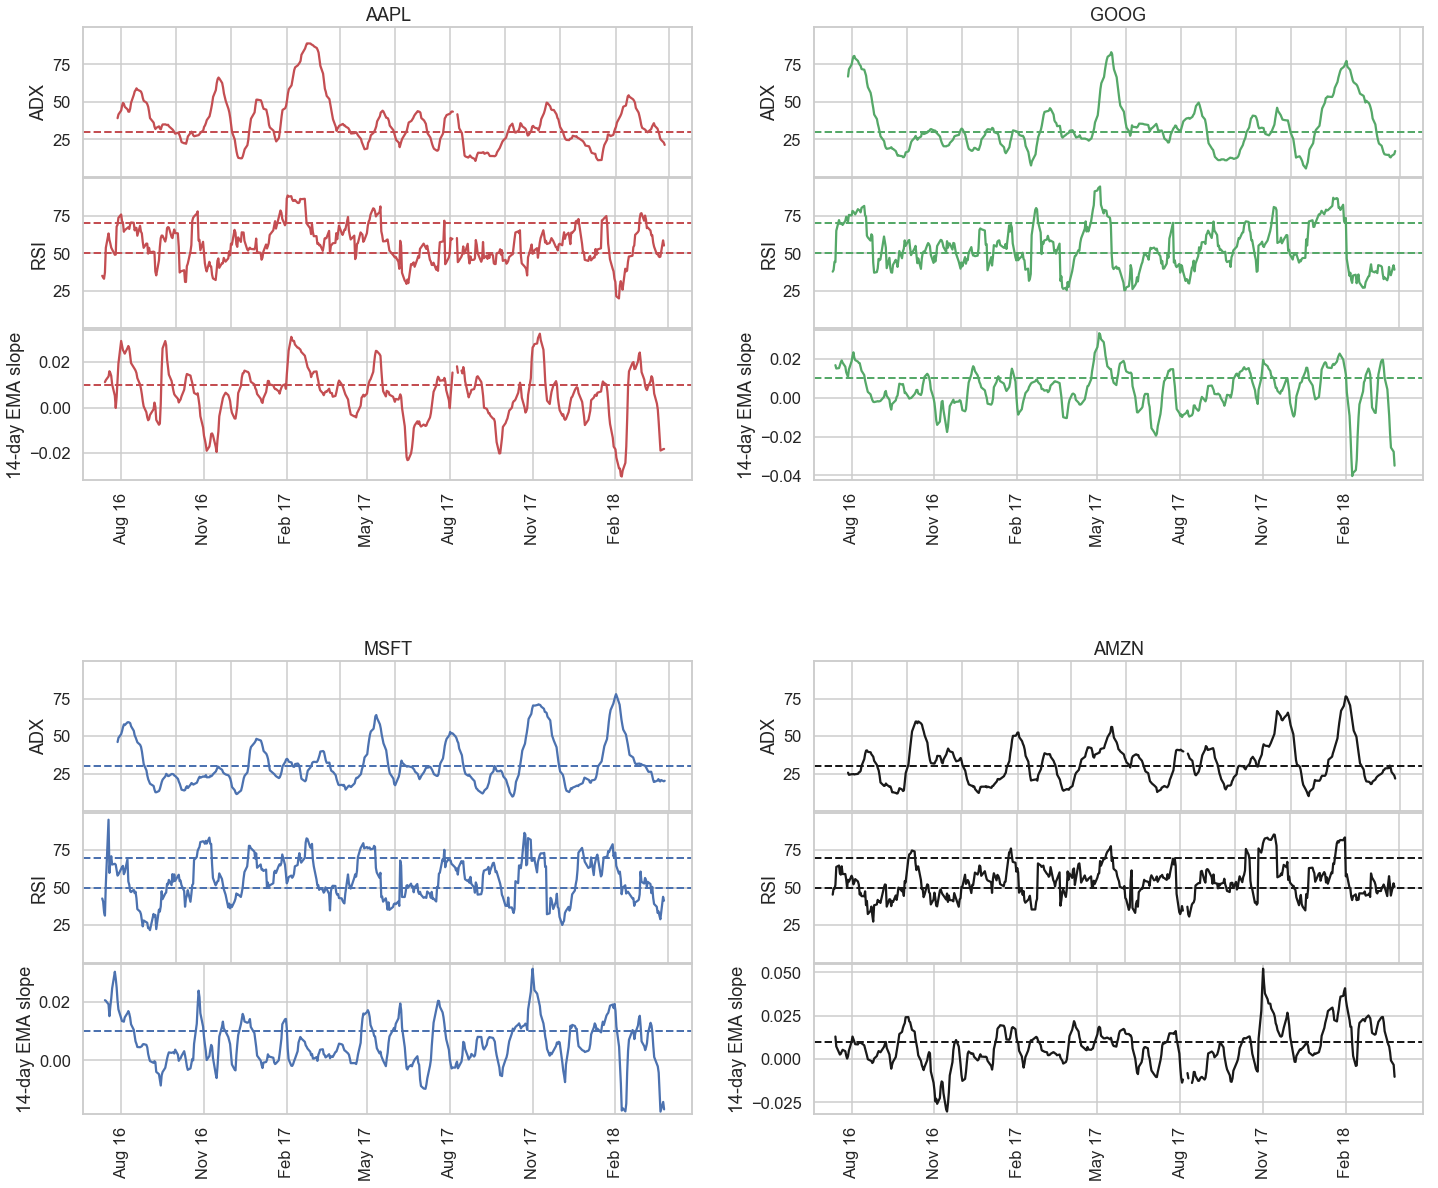

In [52]:
# Buy signal occurs when ADX > bt_ADX, slope > t_slope, RSI > bt_RSI, AND price > 14-day EMA

bt_ADX = 30 # minimum value of ADX to trigger a buy signal
t_slope = 0.01 # minimum slope of the 14-day EMA graph to trigger a buy signal, max slope to trigger a sell signal
bt_RSI = 70 # minimum value of RSI to trigger a buy signal
order = 100 # number of shares to order in a buy order

# Sell signal occurs when RSI falls below a minimum, slope < t_slope, OR price < 14-day EMA
st_RSI = 50 # minimum RSI

#For each stock, graph the ADX immediately above the RSI
col_list = ['ADX','RSI','14-day EMA slope']
fig = plt.figure(figsize=(24,20))
startdate = datetime.strptime(start,'%m/%d/%Y')
gs = gridspec.GridSpec(2,2,figure=fig,hspace=0.4)

for i, stock in enumerate(tech_list):
    gss = gridspec.GridSpecFromSubplotSpec(3,1,
            subplot_spec=gs[i], wspace=0.0, hspace=0.01)
    
    for j, col in enumerate(col_list):
        ax = plt.Subplot(fig,gss[j])
        ax.plot(stocks_df[(col,stock)],color=colors[i])
        
        # Set the y axis label
        ax.set_ylabel(col)
        
        # Set the x axis limits
        ax.set_xlim(startdate,)
        ax.set_xticklabels([])
        
        if j == 0: # top plot
            ax.set_title(stock)
        elif j == 2: # bottom plot
            # Format the x tick labels as a date for every third month
            #triMonths = mdates.MonthLocator(interval = 3)  # every third month
            ax.xaxis.set_major_locator(triMonths)
            #tickFmt = mdates.DateFormatter('%b %y')
            ax.xaxis.set_major_formatter(tickFmt)
        
        if col == 'ADX': 
            # Graph a dashed horizontal line at the ADX buy threshold
            ax.axhline(bt_ADX,lw=2,linestyle='--',color=colors[i])
            ax.set_ylim(0,100)
        elif col == 'RSI': 
            # Graph dashed horizontal lines at the buy and sell RSI thresholds
            [ax.axhline(y,lw=2,linestyle='--',color=colors[i]) for y in [st_RSI,bt_RSI]]
            ax.set_ylim(0,100)
        else: 
            ymin = 1.05*stocks_df[(col,stock)].min()
            ymax = 1.05*stocks_df[(col,stock)].max()
            # Graph a dashed horizontal line at the slope threshold
            ax.axhline(0.01,lw=2,linestyle='--',color=colors[i])
            ax.set_ylim(ymin,ymax)

        # Rotate the ticks 90 degrees
        [tick.set_rotation(90) for tick in ax.get_xticklabels()]                
        
        # Remove the top and bottom y ticks on each graph for better readability
        ticks = ax.get_yticks().tolist()
        ticks = ticks[1:-1]
        ax.set_yticks(ticks)
        
        fig.add_subplot(ax)

<p>Now we will simulate buying and selling of stocks based on this strategy and determine the profit made at the end of the 6-month period. Two cases will be simulated: 1) orders are executed at the end of the day when the stock closes (called the "closing margin") and 2) buy orders are executed at the lowest price of the stock during the day, while sell orders are executed at the highest price (called the "extreme margin").</p>

In [53]:
# Create a function that generates buy and sell triggers
def ADX_RSI_Triggers(close,EMA_14_day,slope,RSI,ADX,t_slope,bt_RSI,bt_ADX,st_RSI):
    # inputs 
    # close - series of closing stock prices
    # EMA_14_day - series of the 14-day exponential moving average of the stock
    # slope - series of the normalized slope of the 14-day exponential moving average graph
    # RSI - series of the RSI of the stock
    # ADX - series of the ADX of the stock
    # t_slope - threshold slope: when the slope goes above this threshold, a buy can be triggered; 
    #                            when below the threshold, a sell signal can be triggered.
    # bt_RSI - buying RSI threshold: when the RSI exceeds this threshold, a buy signal can be triggered
    # bt_ADX - buying ADX threshold: when the ADX exceeds this threshold, a buy signal can be triggered
    # st_RSI - seeling RSI threshold: when teh RSI dips below this threshold, a sell signal will be triggered
    
    # There are four conditions necessary to trigger a buy signal. Create a series of boolean values for each 
    # condition. Finally, create a buy signal on that date if all four conditions are met.
    
    buy_price = close > EMA_14_day
    buy_slope = slope > t_slope
    buy_RSI = RSI > bt_RSI
    buy_ADX = ADX > bt_ADX
    buy = buy_price & buy_slope & buy_RSI & buy_ADX

    # Only trigger a buy on the first day in a set of consecutive dates. 
    # To do this, use the logical statement: buy(n) & not(buy(n-1))
    buy = buy[1:] & ~(buy.shift(periods=1))[1:].values.astype(bool)
    buy = buy.loc[buy]

    # There are three conditions that can trigger a sell signal. Create a series of boolean values for each
    # condition. Finally, create a sell signal on that day if any of the three conditions are met.
    sell_RSI = RSI < st_RSI
    sell_slope = slope < t_slope
    sell_price = close < EMA_14_day
    sell = sell_RSI  | sell_slope | sell_price

    # Only use the first day in a set of consecutive dates. 
    # To do this, use the logical statement: sell(n) & not(sell(n-1))
    sell = sell[1:] & ~(sell.shift(periods=1))[1:].values.astype(bool)
    sell = sell.loc[sell]

    return pd.concat([buy,sell],axis=1).rename(columns={0:'buy',1:'sell'}).fillna(value=False)
    #return triggers.fillna(value=False,inplace=True)

In [51]:
def Sim_RDI_ADX_Trading(close,high,low,EMA_14_day,slope,RSI,ADX,t_slope,bt_RSI,bt_ADX,st_RSI,order):
    # inputs 
    # close - series of closing stock prices
    # high - series of high stock prices
    # low - series of low stock prices
    # EMA_14_day - series of the 14-day exponential moving average of the stock
    # slope - series of the normalized slope of the 14-day exponential moving average graph
    # RSI - series of the RSI of the stock
    # ADX - series of the ADX of the stock
    # t_slope - threshold slope: when the slope goes above this threshold, a buy can be triggered; 
    #                            when below the threshold, a sell signal can be triggered.
    # bt_RSI - buying RSI threshold: when the RSI exceeds this threshold, a buy signal can be triggered
    # bt_ADX - buying ADX threshold: when the ADX exceeds this threshold, a buy signal can be triggered
    # st_RSI - seeling RSI threshold: when teh RSI dips below this threshold, a sell signal will be triggered
    # order - the number of shares to be purchased in each buy order
    
    # Create three lists for computation
        # account_cl - cash account assuming buys and sells occur only at the closing price
        # account_ex - cash account assuming buys occur at the low price and sells occur at the high price
        # shares - the number of shares held
    account_cl = [0]
    account_ex = [0]
    shares = [0]
        
    # Create a pandas DataFrame containing the buy and sell triggers
    history = ADX_RSI_Triggers(close,EMA_14_day,slope,RSI,ADX,t_slope,bt_RSI,bt_ADX,st_RSI)
    
    for date,trigger in history.iterrows():
        if trigger['buy']:
            account_cl.append(account_cl[-1]-float(order*close.loc[date]))
            account_ex.append(account_ex[-1]-float(order*low.loc[date]))
            shares.append(shares[-1]+order)
        if trigger['sell']:
            account_cl.append(account_cl[-1]+float(shares[-1]*close.loc[date]))
            account_ex.append(account_ex[-1]+float(shares[-1]*high.loc[date]))
            shares.append(0)
        print("Date: {0:}, shares: {2:3d}, margin(closing): {3:+9.2f}, margin(extreme): {4:+9.2f}".format(date.date(),shares[-1],account_cl[-1],account_ex[-1]))

    # Sell any remaining shares at the end of the time period
    if shares[-1] > 0:
        account_cl.append(account_cl[-1]+float(shares[-1]*close.loc[date]))
        account_ex.append(account_ex[-1]+float(shares[-1]*high.loc[date]))
        shares.append(0)
        print("Date: {0:}, shares: {2:3d}, margin(closing): {3:+9.2f}, margin(extreme): {4:+9.2f}".format(date.date(),shares[-1],account_cl[-1],account_ex[-1]))
        # Append another row onto the history DataFrame, otherwise there will be a length mismatch
        
    # Append the accounts and shares lists to the DataFrame 
    
    
    # Return the DataFrame
    

Date: 2016-07-11, trigger: sell, shares:   0, margin(closing):     +0.00, margin(extreme):     +0.00
Date: 2016-07-21, trigger: sell, shares:   0, margin(closing):     +0.00, margin(extreme):     +0.00
Date: 2016-07-29, trigger:  buy, shares: 100, margin(closing): -10421.00, margin(extreme): -10368.00
Date: 2016-08-12, trigger:  buy, shares: 200, margin(closing): -21239.00, margin(extreme): -21146.00
Date: 2016-08-19, trigger: sell, shares:   0, margin(closing):   +633.00, margin(extreme):   +792.00
Date: 2016-09-23, trigger: sell, shares:   0, margin(closing):   +633.00, margin(extreme):   +792.00
Date: 2016-12-21, trigger: sell, shares:   0, margin(closing):   +633.00, margin(extreme):   +792.00
Date: 2017-02-02, trigger:  buy, shares: 100, margin(closing): -12220.00, margin(extreme): -11986.00
Date: 2017-02-28, trigger: sell, shares:   0, margin(closing):  +1479.00, margin(extreme):  +1757.50
Date: 2017-03-07, trigger: sell, shares:   0, margin(closing):  +1479.00, margin(extreme): 

<p>For Apple's stock over this two-year period, there were four buying triggers. There were many more sell triggers because only one condition needs to be met to trigger a sell, whereas four are necessary for a buy trigger. For the sake of this discussion, we will review margins from buying/selling at close.</p>
<p>The first two buy triggers occured on July 29 and Aug 12, 2016. An investment of \$21,230 resulted in a return of +\$633 (+3%). The third buy trigger occurred on Feb 2, 2017 with an investment of \$12,833 resulting in a return of \$846 (+6.6%). The final buy trigger occurred on May 15, 2017 with an investment of \$15,570 resulting in a return of -\$316 (-2.0%).</p>
<p>Let's now see if the other three stocks perform similarly.</p>
